# **EXPLANATORY DATA ANALYSIS**

#### IMPORT REQUIRED LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---

#### LOAD DATASET

In [2]:
# Load the Stack Overflow survey data
data_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/n01PQ9pSmiRX6520flujwQ/survey-data.csv'
df = pd.read_csv(data_url)

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

---

#### HANDLE MISSING DATA

Identify and manage missing values in critical columns such as `Employment`, `JobSat`, and `RemoteWork`. Implement a strategy to fill or drop these values, depending on the significance of the missing data.

In [34]:
print(df[['Employment', 'JobSat', 'RemoteWork']].dtypes)
#df[['Employment', 'JobSat', 'RemoteWork']]

Employment     object
JobSat        float64
RemoteWork     object
dtype: object


In [5]:
print(f"Total Rows: {len(df)}")
print(f"Employment missing values: {df['Employment'].isna().sum()}")
print(f"Jobsat missing values: {df['JobSat'].isna().sum()}")
print(f"RemoteWork missing values: {df['RemoteWork'].isna().sum()}")

Total Rows: 65437
Employment missing values: 0
Jobsat missing values: 36311
RemoteWork missing values: 10631


For `Jobsat` and `RemoteWork` i think it's not wise to fill **NaN** with *forward-fill* or *mode*. Dropping them also would be a data *messacre* since the number of missing values are too high, especially for `JobSat` (36311 missing values). I'll fill **NaN** with new category called **'Not Applicable'** for `RemoteWork` and `-1` for `JobSat` as the safest option.

In [6]:
# Fill missing 'JobSat' NaN with new category 'Not Applicable'
df['JobSat'] = df['JobSat'].fillna(-1)

# Fill missing 'RemoteWork' NaN with new category 'Not Applicable'
df['RemoteWork'] = df['RemoteWork'].fillna('Not Applicable')

# Verify
print(f"Number of missing values of Jobsat and RemoteWork:\n{df[['JobSat', 'RemoteWork']].isna().sum()}")

Number of missing values of Jobsat and RemoteWork:
JobSat        0
RemoteWork    0
dtype: int64


---

#### ANALYSIS OF EXPERIENCE AND JOB SATISFACTION

Analyze the relationship between years of professional coding experience (`YearsCodePro`) and job satisfaction (`JobSat`). Summarize `YearsCodePro` and calculate median satisfaction scores based on experience ranges.

- Create experience ranges for `YearsCodePro` (e.g., `0-5`, `5-10`, `10-20`, `>20` years).

- Calculate the median `JobSat` for each range.

- Visualize the relationship using a bar plot or similar visualization.


In [8]:
# Create replace map to change string value to numerical
replace_map = {
    'Less than 1 year' : 0,
    'More than 50 years' : 51
}

# replace string to numerical value
df['YearsCodePro'] = df['YearsCodePro'].replace(replace_map)

# Check number of missing value before converting
print(f"Number of missing values: {df['YearsCodePro'].isna().sum()}")

# Convert all value to numerical
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')

print(f"Number of missing values after converting: {df['YearsCodePro'].isna().sum()}")

Number of missing values: 13827
Number of missing values after converting: 13827


#### Handle missing values first before further analyze the data

Since there are students category in `Employment` column, we will fill `YearsCodePro` with those category with 0 experience first. Then fill the rest with median.

In [10]:
# ---HANDLE MISSING YEARS CODE PRO DATA---
# Create a filter for student and unemployed
student_mask = df['Employment'].str.contains("Student|Not employed", case=False, na=False)
df.loc[student_mask, 'YearsCodePro'] = df.loc[student_mask, 'YearsCodePro'].fillna(0)

# Then fill the rest with median
exp_median = df['YearsCodePro'].median()
df['YearsCodePro'] = df['YearsCodePro'].fillna(exp_median)

print(f"Remaining missing values: {df['YearsCodePro'].isna().sum()}")

Remaining missing values: 0


#### Feature Engineering

In [ ]:
# Create bins and categories
bins = [-1, 2, 5, 10, 52]
labels= ['Junior', 'Mid-level', 'Senior', 'Expert']
df['ExperienceCategory'] = pd.cut(df['YearsCodePro'], bins=bins, labels=labels)

#### Calculate Job Satisfactoin Median for each Experience Category

Since there are numerous **"Student"** category that included as **"Junior"** category, but previously we set their `JobSat` value to -1 ('Not Applicable'). Because of that, i'll filter out `JobSat` with -1 values, so they won't drag the score down, which will intrepreted as *"Juniors hate their job"* (false or miss intrepret).

In [14]:
median_satisfactory = df[df['JobSat'] >= 0].groupby('ExperienceCategory', observed=False)['JobSat'].median()

median_satisfactory

ExperienceCategory
Junior       7.0
Mid-level    7.0
Senior       7.0
Expert       8.0
Name: JobSat, dtype: float64

----

#### VISUALIZE

We'll visualize `JobSat` into a `countplot`

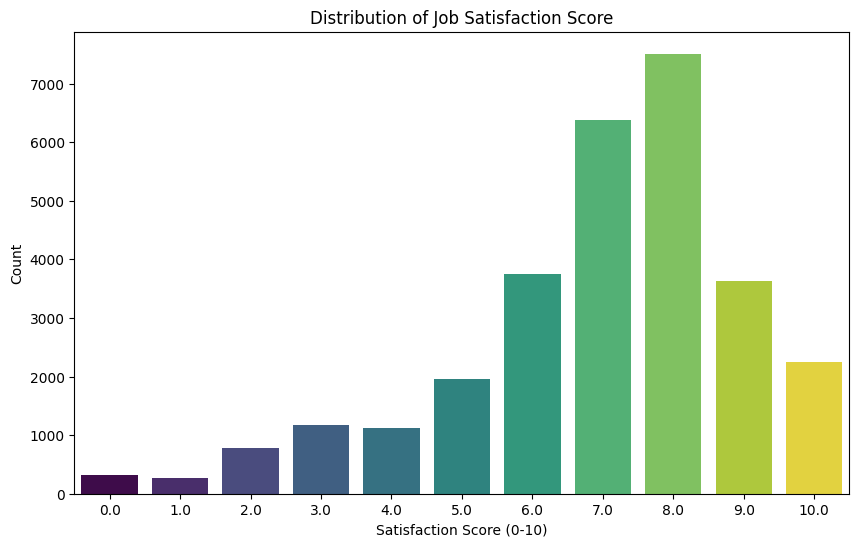

In [32]:
# Create Figure
plt.figure(figsize=(10,6))

# Filter out -1 (not applicable)
applicable = df[df['JobSat'] >= 0]

# Create plot
sns.countplot(x='JobSat', data=applicable, order=sorted(applicable['JobSat'].unique()),
               palette='viridis', hue='JobSat', legend=False)

# Add title and labels
plt.title('Distribution of Job Satisfaction Score')
plt.xlabel('Satisfaction Score (0-10)')
plt.ylabel('Count')

# Display the chart
plt.show()